### ANN as a multi class fault detection model
This notebooks shows how to train and optimize a fault detection model based on an artifical neural network. Choose a model name and decide on the dataset to use.

In [1]:
import torch
from fermfaultdetect.utils import get_simulation_dir, get_models_dir
from fermfaultdetect.data.utils import load_batchset, dataloader
import os
from fermfaultdetect import model_evaluation as eval
import json
import wandb
import numpy as np
import pandas as pd
from fermfaultdetect.fault_detect_models.ml_models import nn_fdm
from fermfaultdetect.visualizations import visualize
from fermfaultdetect.model_evaluation import plot_example_set
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import json

seed = 42 # set seeding for reproducibility

### Load data

In [13]:
sim_dir = get_simulation_dir() # get directory of simulation data

### Choose model name and data set ###
model_name = "FILL_IN_MODEL_NAME"
train_set_name = "FILL_IN_TRAINING_SET_NAME"
val_set_name = "FILL_IN_VALIDATION_SET_NAME"
######################################

# Should feature engineering be applied?
FE_airflow = False

train_path = os.path.join(sim_dir, train_set_name)
val_path = os.path.join(sim_dir, val_set_name)

# set directory to save model and metrics
model_dir = os.path.join(get_models_dir(), model_name)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

train_set = load_batchset(train_path)
val_set = load_batchset(val_path)

target_cols = ['defect_steambarrier', 'steam_in_feed', 'blocked_spargers', 'airflow_OOC', 'OUR_OOC', 'no_fault'] # target columns without feature engineering    

# Load train data into dataloader and standardize
batch_size = 1
train_dl = dataloader(batchset = train_set[:], batch_size=batch_size, seed=seed)
train_dl.shuffle_batches()
train_dl.standardize_data(exclude_cols=target_cols)

# Load test data into dataloader and standardize
val_dl = dataloader(batchset = val_set[:], seed=seed)
val_dl.import_standardization(train_dl)
val_dl.standardize_data(exclude_cols=target_cols)

# Retrieve data from dataloader with separate and fused target columns
val_X, val_Y = val_dl.get_data(split_batches=False, target_cols=target_cols, separate_target_matrix=True, fuse_target_cols=True)
val_X_tensor, val_Y_tensor = torch.tensor(val_X.values, dtype=torch.float32), torch.tensor(val_Y.values, dtype=torch.float32)
_, val_Y_unfused = val_dl.get_data(split_batches=False, target_cols=target_cols, separate_target_matrix=True, fuse_target_cols=False)

# Prepare training data iterator
train_dl.prepare_iterator_data(target_cols=target_cols, one_class = True)

# Turn on wandb logging if wanted
use_wandb = False

## Train single model

### ANN setup

In [14]:
# Hyperparameters
input_dim = 8
output_dim = 2
mw = 1 # moving time window
epochs = 100
learning_rate = 1e-3
penalty_class = 0

# Initial guesses, will be optimized later on
hidden_layer = [40]
weight_decay= 1e-8
false_alarm_penalty=1.0

if use_wandb:
    wandb.init(
        # set the wandb project where this run will be logged
        project="ferm_fdm",

        # track hyperparameters and run metadata
        config={
        "model": "ANN_detect",
        "name": model_name,
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "architecture": hidden_layer,
        "train_set": train_set_name,
        "epochs": epochs,
        "false_alarm_penalty": false_alarm_penalty,
        "moving time window": mw
        }
    )

# Initialize model
nn_model = nn_fdm(input_dim, output_dim, hidden_layer, mode="one_class", mw=mw, seed=seed, use_wandb=use_wandb)

### Train model

In [ ]:
nn_model.train(train_dl=train_dl, test_X=val_X, test_Y=val_Y, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, weight_decay=weight_decay, penalty_class=penalty_class, false_alarm_penalty=false_alarm_penalty)

## Optimize model

### Gridsearch to optimize number of nodes and weight decay

In [ ]:
nodes_grid = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
weight_decay_grid = [1e-2, 1e-4, 1e-6, 1e-8]


#ANN setup
input_dim = 8
output_dim = 2
mw = 1
epochs = 100 # at least 2 epochs
learning_rate = 1e-3
false_alarm_penalty = 1.0
early_stopping = None

results = []
best_acc = 0

# Loop through all possible combinations
for nodes in nodes_grid:
    for wd in weight_decay_grid:
        print(f"Training model with nodes={nodes} and weight_decay={wd}")
        hidden_layer = [nodes]
        nn_model_grid = nn_fdm(input_dim, output_dim, hidden_layer, mw, seed=seed, use_wandb=use_wandb)
        nn_model_grid.mode = "one_class"
        nn_model_grid.train(train_dl=train_dl, test_X=val_X, test_Y=val_Y, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, weight_decay=wd, penalty_class=0, false_alarm_penalty=false_alarm_penalty, print_progress=False, early_stopping=early_stopping)
        pred_tensor = nn_model_grid.net(val_X_tensor)
        accuracy, _, _ = nn_model_grid.prediction_accuracy(pred_tensor=pred_tensor,test_Y=val_Y)
        if accuracy > best_acc:
            best_nn_model = nn_model_grid
        results.append({
            'nodes': nodes,
            'weight_decay': wd,
            'accuracy': accuracy
        })

# Convert results tp pivot table
results_df = pd.DataFrame(results)
pivot_table = results_df.pivot(index='nodes', columns='weight_decay', values='accuracy')
table_path = os.path.join(model_dir, "ann_oneclass_gridsearch_heatmap.csv")
pivot_table.to_csv(table_path)

# Save best model
filename = 'best_model.pth' # set model name
save_path = os.path.join(model_dir, filename)
best_nn_model.save_model(save_path)

In [ ]:
# Print optimal hyperparameters
best_row = results_df.loc[results_df['accuracy'].idxmax()]
print(f"Optimal parameters: accuracy = {best_row['accuracy']:.3f}, Nodes = {best_row['nodes']:.3f}, weight_decay = {best_row['weight_decay']}")

# Plotting the results using seaborn heatmap
plt.figure(figsize=(10, 8))
visualize.set_plot_params(high_res=True)
ax = sns.heatmap(pivot_table, annot=False, cmap=visualize.get_hotcold_colormap(), fmt=".3f")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.xlabel('Weight decay [-]')
plt.ylabel('Nodes in hidden layer [-]')
plt.savefig(os.path.join(model_dir, "ann_gridsearch_heatmap_"+model_name+".png"), dpi=300)
plt.show()

### Optimize false alarm penalty

In [ ]:
### Enter optimal number nodes and weight decay ###
hidden_layer = [60]
weight_decay = 1e-6
###################################################

# Choose grid
penalty_grid = [1, 2, 3, 5, 10]

penalty_class = 5 # 5 = penalize false alarms

accuracy_penalty = []
FDR_penalty = []
FAR_penalty = []
models = []

# Loop through all possible combinations
for penalty in penalty_grid:
    print(f"Training model with false alarm penalty = {penalty}")
    false_alarm_penalty = penalty
    nn_model_penalty = nn_fdm(input_dim, output_dim, hidden_layer, mw, seed=seed, use_wandb=use_wandb)
    nn_model_penalty.mode = "one_class"
    nn_model_penalty.train(train_dl=train_dl, test_X=val_X, test_Y=val_Y, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, weight_decay=weight_decay, penalty_class=penalty_class, false_alarm_penalty=false_alarm_penalty, print_progress=False, early_stopping=early_stopping)
    pred_tensor = nn_model_penalty.net(val_X_tensor)
    accuracy, FDR, FAR = nn_model_penalty.prediction_accuracy(pred_tensor=pred_tensor,test_Y=val_Y)
    accuracy_penalty.append(accuracy)
    FDR_penalty.append(FDR)
    FAR_penalty.append(FAR)
    models.append(nn_model_penalty)

In [ ]:
# Plotting the cumulative explained variance to determine the number of components to retain
colors = visualize.get_thesis_colors()
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(penalty_grid, FDR_penalty, color=colors["blue"], marker='o', linestyle=None, label='Fault detection rate')
ax1.set_xlabel('False alarm penalty factor [-]')
ax1.set_ylabel('Fault detection rate [-]', color=colors["blue"])

ax2 = ax1.twinx()
ax2.plot(penalty_grid, FAR_penalty, color=colors["red"], marker='s', linestyle=None, label='False alarm rate')
ax2.set_ylabel('False alarm rate [-]', color=colors["red"])
ax2.set_yticks([0.004, 0.003, 0.002, 0.001, 0.000])
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.95), frameon=False)

#plt.rcParams['figure.dpi'] = 300  # High resolution for saving
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Save the plot
plt.tight_layout()
plt.savefig(os.path.join(model_dir, model_name+"_penalty.png"), dpi=300)
plt.show()

In [22]:
###### Choose optimal false penalty factor and save corresponding model ######
preferred_penalty = 3
best_nn_model_penalty = models[penalty_grid.index(preferred_penalty)]
##############################################################################

# Save model
filename = 'best_model_with_penalty.pth' # set model name
save_path = os.path.join(model_dir, filename)
best_nn_model_penalty.save_model(save_path)

# Create and save config
config_model = {
    "model": "ANN_oneclass",
    "date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "train_set": train_set_name,
    "name": model_name,
    "learning_rate": learning_rate,
    "weight_decay": weight_decay,
    "architecture": hidden_layer,
    "input_dim": input_dim,
    "output_dim": output_dim,
    "epochs": epochs,
    "false_alarm_penalty": preferred_penalty,
    "moving time window": mw
}

# Save the model config as a json file
config_name = "config.json"
config_path = os.path.join(model_dir, config_name)
with open(config_path, 'w') as json_file:
    json.dump(config_model, json_file, indent=4)

### Analyse performance of optimal model on validation data set

In [ ]:
predictions_df = best_nn_model_penalty.predict(val_X_tensor, output_columns=val_Y.columns)
#_, test_Y_unfused = test_dl.get_data(split_batches=False, target_cols=target_cols, separate_target_matrix=True, fuse_target_cols=False)
filepath = os.path.join(model_dir, "ann_oneclass_metrics.csv") # can be passed to metrics_table
metrics = eval.metrics_table_multclass(val_Y, predictions_df, show_confusion_matrix=True, save_path=filepath)
eval.visualize_metrics(metrics, save_path=model_dir)

if use_wandb:
    wandb.run.summary["accurary"] = metrics.loc["overall"]["Accuracy"]
    wandb.run.summary["FDR"] = metrics.loc["overall"]["Fault detection rate"]
    wandb.run.summary["FAR"] = metrics.loc["overall"]["False alarm rate"]
    wandb.run.summary["defect_steambarrier"] = metrics.loc["defect_steambarrier"]["Fault detection rate"]
    wandb.run.summary["steam_in_feed"] = metrics.loc["steam_in_feed"]["Fault detection rate"]
    wandb.run.summary["blocked_spargers"] = metrics.loc["blocked_spargers"]["Fault detection rate"]
    wandb.run.summary["airflow_OOC"] = metrics.loc["airflow_OOC"]["Fault detection rate"]
    wandb.run.summary["OUR_OOC"] = metrics.loc["OUR_OOC"]["Fault detection rate"]

    wandb.finish()

## Analyse existing model

In [4]:
# Load model
model_name_load = "FILL_MODEL_NAME" # choose model to load
model_dir = os.path.join(get_models_dir(), model_name_load)
filename = 'model.pth'
save_path = os.path.join(model_dir, filename)

nn_model = nn_fdm(input_dim, output_dim, hidden_layer, mw=mw)
nn_model.load_model(save_path)
nn_model.mode = "one_class"
nn_model.target_cols = target_cols

### Summary metrics

In [5]:
# Save predictions as dataframe to perform evaluation
predictions_df = nn_model.predict(val_X_tensor, output_columns=val_Y.columns)

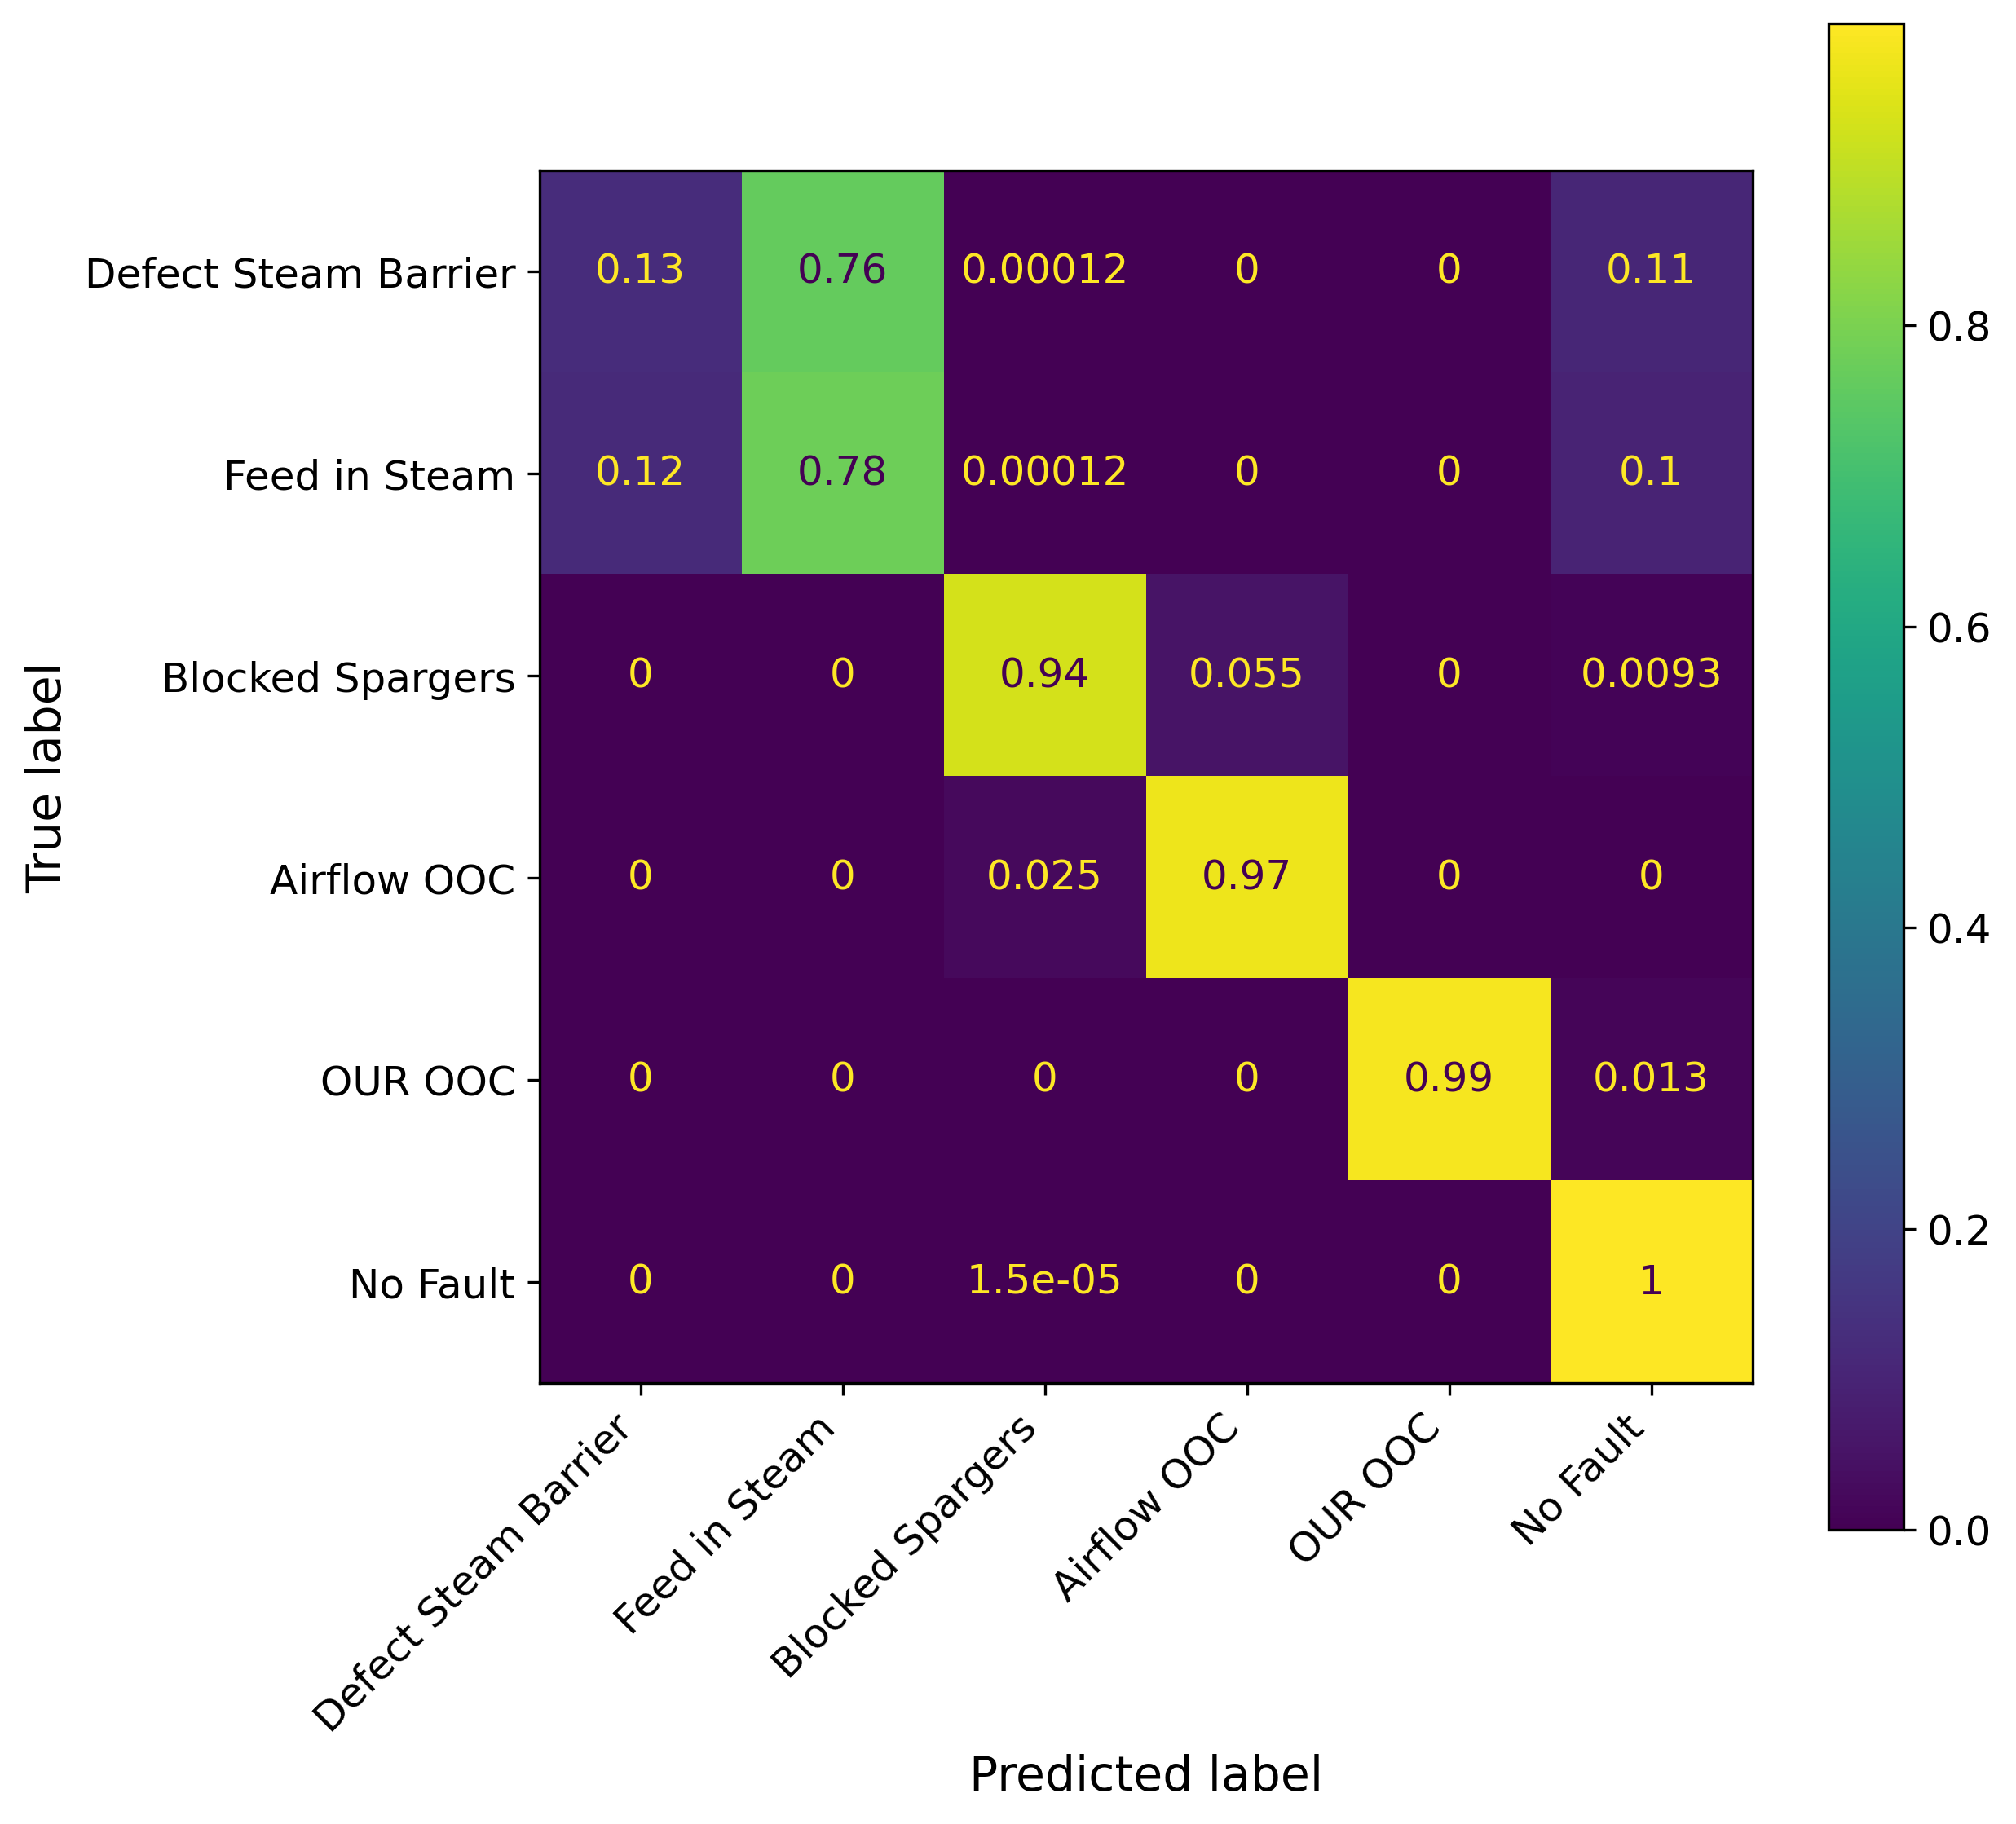

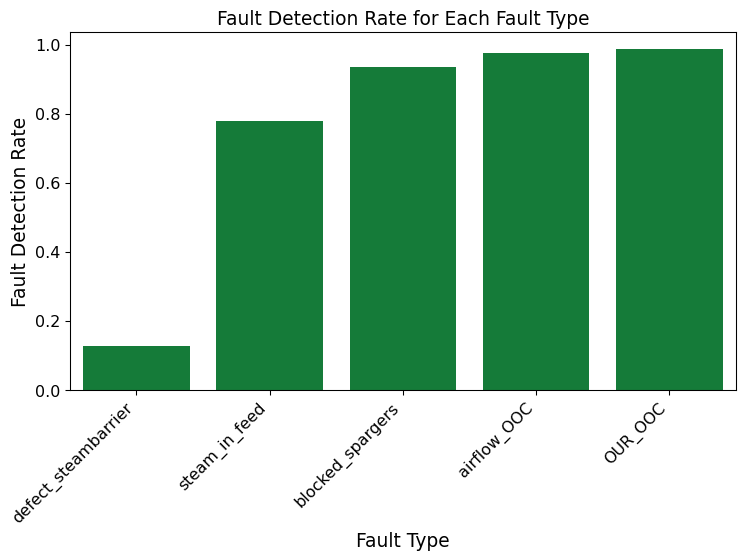

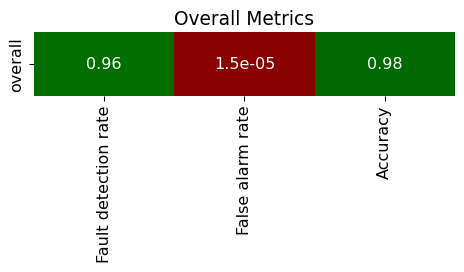

In [6]:
filepath = os.path.join(model_dir, "ann_oneclass_metrics.csv") # can be passed to metrics_table
metrics = eval.metrics_table_oneclass(val_Y, predictions_df, show_confusion_matrix=True, save_path=filepath)
eval.visualize_metrics(metrics, save_path=model_dir)

if use_wandb:
    wandb.run.summary["accurary"] = metrics.loc["overall"]["Accuracy"]
    wandb.run.summary["FDR"] = metrics.loc["overall"]["Fault detection rate"]
    wandb.run.summary["FAR"] = metrics.loc["overall"]["False alarm rate"]
    wandb.run.summary["defect_steambarrier"] = metrics.loc["defect_steambarrier"]["Fault detection rate"]
    wandb.run.summary["steam_in_feed"] = metrics.loc["steam_in_feed"]["Fault detection rate"]
    wandb.run.summary["blocked_spargers"] = metrics.loc["blocked_spargers"]["Fault detection rate"]
    wandb.run.summary["airflow_OOC"] = metrics.loc["airflow_OOC"]["Fault detection rate"]
    wandb.run.summary["OUR_OOC"] = metrics.loc["OUR_OOC"]["Fault detection rate"]

    wandb.finish()

### Visualize model predictions on chosen dataset
This parts allows to visually inspect the performance of the model for a set of batches.

In [ ]:
example_setname = val_set_name
plot_example_set(model=nn_model, dataset_name=example_setname, parameter_plotted="weight", target_cols=target_cols, combine_steam_faults=True, combined_figure=False)